In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/aptos2019-blindness-detection/train.csv
/kaggle/input/aptos2019-blindness-detection/sample_submission.csv
/kaggle/input/aptos2019-blindness-detection/test.csv
/kaggle/input/aptos2019-blindness-detection/test_images/42bef0737ac1.png
/kaggle/input/aptos2019-blindness-detection/test_images/6d51db325a98.png
/kaggle/input/aptos2019-blindness-detection/test_images/95485b752436.png
/kaggle/input/aptos2019-blindness-detection/test_images/cd45c48db97d.png
/kaggle/input/aptos2019-blindness-detection/test_images/643ff5d1f90f.png
/kaggle/input/aptos2019-blindness-detection/test_images/d9b846ab7972.png
/kaggle/input/aptos2019-blindness-detection/test_images/e1a9cafeb308.png
/kaggle/input/aptos2019-blindness-detection/test_images/80ffe924f95b.png
/kaggle/input/aptos2019-blindness-detection/test_images/c7c003cdaaba.png
/kaggle/input/aptos2019-blindness-detection/test_images/d1a276276890.png
/kaggle/input/aptos2019-blindness-detection/test_images/21d65a5b8d67.png
/kaggle/input/aptos2019-

/kaggle/input/aptos2019-blindness-detection/train_images/ff77e8e5b5f3.png
/kaggle/input/aptos2019-blindness-detection/train_images/ce207b69ff37.png
/kaggle/input/aptos2019-blindness-detection/train_images/849a91e9ab28.png
/kaggle/input/aptos2019-blindness-detection/train_images/e4e343eaae2a.png
/kaggle/input/aptos2019-blindness-detection/train_images/367c7049929c.png
/kaggle/input/aptos2019-blindness-detection/train_images/80c67efc8101.png
/kaggle/input/aptos2019-blindness-detection/train_images/19244004583f.png
/kaggle/input/aptos2019-blindness-detection/train_images/de4cdabbce6d.png
/kaggle/input/aptos2019-blindness-detection/train_images/726dff37edc0.png
/kaggle/input/aptos2019-blindness-detection/train_images/0fcfc6301f3d.png
/kaggle/input/aptos2019-blindness-detection/train_images/69df7ade0575.png
/kaggle/input/aptos2019-blindness-detection/train_images/8aab201c0691.png
/kaggle/input/aptos2019-blindness-detection/train_images/4661006f3ba6.png
/kaggle/input/aptos2019-blindness-dete

/kaggle/input/aptos2019-blindness-detection/train_images/c1437a7a52c9.png
/kaggle/input/aptos2019-blindness-detection/train_images/6ea07d19b4ce.png
/kaggle/input/aptos2019-blindness-detection/train_images/996f57c86ba5.png
/kaggle/input/aptos2019-blindness-detection/train_images/c85b79d70079.png
/kaggle/input/aptos2019-blindness-detection/train_images/fce73678f650.png
/kaggle/input/aptos2019-blindness-detection/train_images/17d7d6b092f4.png
/kaggle/input/aptos2019-blindness-detection/train_images/15b21c80cc31.png
/kaggle/input/aptos2019-blindness-detection/train_images/bc92a61a1f9c.png
/kaggle/input/aptos2019-blindness-detection/train_images/cb28adab4e8a.png
/kaggle/input/aptos2019-blindness-detection/train_images/abdb365cacbc.png
/kaggle/input/aptos2019-blindness-detection/train_images/e265c870f9b3.png
/kaggle/input/aptos2019-blindness-detection/train_images/6cd606dc52e9.png
/kaggle/input/aptos2019-blindness-detection/train_images/ee059945b08a.png
/kaggle/input/aptos2019-blindness-dete

In [0]:
# Import support libraries
import cv2
import json
import math
import os
from PIL import Image
from zipfile import ZipFile

# Import libraries for scientific computing and plotting 
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import TensorFlow, Keras, Sklearn
import tensorflow as tf
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Print out some versions
print(tf.__version__)
print(np.__version__)
print(pd.__version__)
print ()
# Print out list of input files
print(os.listdir("../input/aptos2019-blindness-detection"))

%matplotlib inline


2.0.0
1.16.4
0.25.2

['train.csv', 'sample_submission.csv', 'test_images', 'test.csv', 'train_images']


In [0]:
#COLOR CLAHE FUNC
def enhance(image_path, clip_limit=3):
    image = cv2.imread(image_path, 1)
    # convert image to LAB color model
    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # split the image into L, A, and B channels
    l_channel, a_channel, b_channel = cv2.split(image_lab)

    # apply CLAHE to lightness channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L channel with the original A and B channel
    merged_channels = cv2.merge((cl, a_channel, b_channel))

    # convert iamge from LAB color model back to RGB color model
    final_image = cv2.cvtColor(merged_channels, cv2.COLOR_LAB2BGR)
    return final_image

In [0]:
# read data
IMG_SIZE = 512


train_data = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
print('{} samples'.format(len(train_data)))

test_data = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
print('{} tests'.format(len(test_data)))

train_ids = train_data['id_code'].values
train_labels = train_data['diagnosis'].values

test_ids = test_data['id_code'].values

3662 samples
1928 tests


In [0]:
TRAIN_PATH = '../input/aptos2019-blindness-detection/train_images'
TEST_PATH = '../input/aptos2019-blindness-detection/test_images'

In [0]:
# Import support libraries
import cv2
import json
import math
import os
from PIL import Image
from zipfile import ZipFile

# Import libraries for scientific computing and plotting 
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import TensorFlow, Keras, Sklearn
import tensorflow as tf
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Print out some versions
print(tf.__version__)
print(np.__version__)
print(pd.__version__)
print ()
# Print out list of input files
print(os.listdir("../input/aptos2019-blindness-detection"))

%matplotlib inline

2.0.0
1.16.4
0.25.2

['train.csv', 'sample_submission.csv', 'test_images', 'test.csv', 'train_images']


In [0]:
print(os.listdir("../input/"))

['aptos2019-blindness-detection']


In [0]:
## Function to pre-process the images
def preprocess_image(image_path, desired_size=224):
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (desired_size,desired_size))
    im = cv2.addWeighted(im,4,cv2.GaussianBlur(im, (0,0), desired_size/30) ,-4 ,128)
    return im

In [0]:
N = train_data.shape[0]
x_train = np.empty((N, 224,224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_data['id_code'])):
    x_train[i, :, :, :] = preprocess_image(f'../input/aptos2019-blindness-detection/train_images/{image_id}.png')

100%|██████████| 3662/3662 [04:27<00:00, 13.67it/s]


In [0]:
y_train = pd.get_dummies(train_data['diagnosis']).values
y_train_single = train_data['diagnosis']
train_label = []
for x_1 in range(train_data.shape[0]):
    data = train_data['diagnosis'][x_1]
    train_label.append(data)

train_label = np.array(train_label)
print(x_train.shape)
print(y_train.shape)

(3662, 224, 224, 3)
(3662, 5)


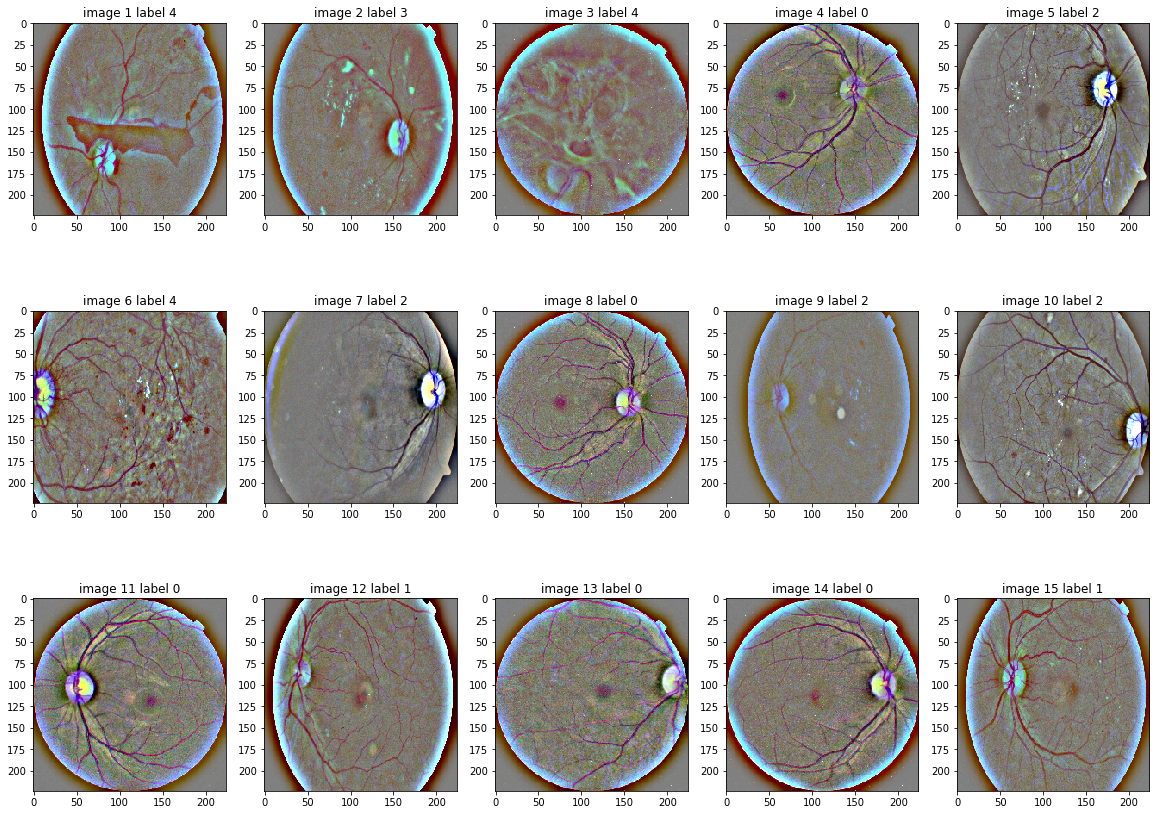

viridis


In [0]:
# randomly show 15 images

plt.figure(figsize=(20, 15))
idx = np.random.randint(0, len(x_train), size=15)

for i in range(15):
    plt.subplot(3, 5, i+1)
    im = x_train[idx[i]][..., [2, 1, 0]] # tranverse RGB to 
    im = plt.imshow(im)
    plt.title('image %s label %s' % (i+1, np.argmax(y_train[idx[i]])))
plt.show()
print(im.get_cmap().name)

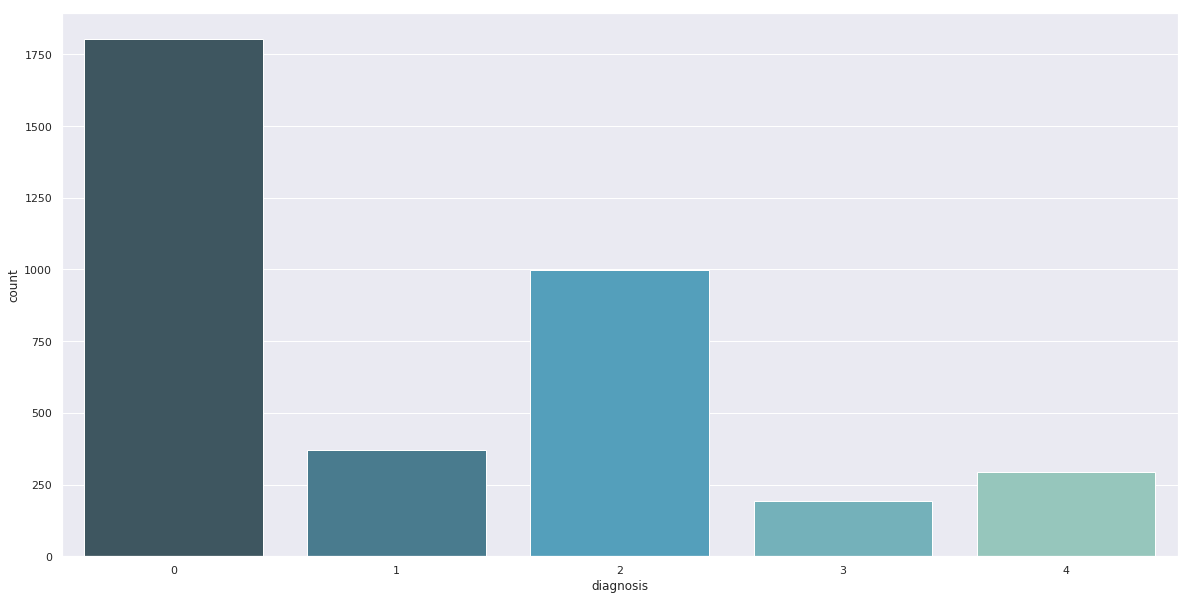

In [0]:
# show label distrubtion
import seaborn as sns
plt.figure(figsize=(20, 10))
sns.set(style='darkgrid')
ax= sns.countplot(x='diagnosis', data=train_data, palette="GnBu_d") # accept pd.DataFrame
plt.show()

In [0]:
# customized metric.accuracy
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t) # tensor 1 / 0
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score) # no change
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='elu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='elu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='elu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='elu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [0]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['mae', 'accuracy'])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 128)      

In [0]:
from sklearn.utils import class_weight

weight = class_weight.compute_class_weight('balanced', np.unique(train_label), train_label)
cw = dict(enumerate(weight))
print(cw)


{0: 0.4057617728531856, 1: 1.9794594594594594, 2: 0.7331331331331331, 3: 3.7948186528497407, 4: 2.4827118644067796}


In [0]:
# learning rate schedule
import math
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
 

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

earlystopping = EarlyStopping(patience=5, verbose=1)
lrate = keras.callbacks.LearningRateScheduler(step_decay)
model_checkpoint = ModelCheckpoint('../input/model-cnn-generate_aptos.h5', monitor='val_acc', save_best_only='True')
checkpoint_list = [ earlystopping, model_checkpoint]

In [0]:
#Data Augmentation
from keras.preprocessing.image import ImageDataGenerator
gen_train = ImageDataGenerator(
        rotation_range = 25,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode='nearest'
)
gen_train.fit(x_train)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
print('The shape of X_train is:', X_train.shape)
print('The shape of y_train is:', Y_train.shape)
print('The shape of X_test is:', X_test.shape)
print('The shape of y_test is:', Y_test.shape)

The shape of X_train is: (2929, 224, 224, 3)
The shape of y_train is: (2929, 5)
The shape of X_test is: (733, 224, 224, 3)
The shape of y_test is: (733, 5)


In [0]:
batch_size = 32
epochs = 25
history = model.fit_generator(gen_train.flow(x=X_train, y=Y_train, batch_size=batch_size, shuffle=True),
                       steps_per_epoch = (x_train.shape[0]//(batch_size)),
                        epochs = epochs,
                        validation_data=(X_test, Y_test),
                        class_weight=cw,
                         callbacks = checkpoint_list,verbose=1)

Epoch 1/25
114/114 [==============================] - 40s 347ms/step - loss: 13.0921 - mae: 0.3674 - accuracy: 0.0815 - val_loss: 14.6901 - val_mae: 0.3645 - val_accuracy: 0.0887
Epoch 2/25
  1/114 [..............................] - ETA: 11s - loss: 11.8258 - mae: 0.3625 - accuracy: 0.0938

/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


114/114 [==============================] - 36s 319ms/step - loss: 12.5770 - mae: 0.2264 - accuracy: 0.4341 - val_loss: 8.4087 - val_mae: 0.2085 - val_accuracy: 0.4789
Epoch 3/25
  1/114 [..............................] - ETA: 11s - loss: 14.8860 - mae: 0.2250 - accuracy: 0.4375

/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


114/114 [==============================] - 36s 316ms/step - loss: 12.9877 - mae: 0.2002 - accuracy: 0.4994 - val_loss: 8.4087 - val_mae: 0.2085 - val_accuracy: 0.4789
Epoch 4/25
  1/114 [..............................] - ETA: 9s - loss: 9.7300 - mae: 0.1750 - accuracy: 0.5625

/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


114/114 [==============================] - 36s 314ms/step - loss: 12.8222 - mae: 0.2016 - accuracy: 0.4960 - val_loss: 8.4087 - val_mae: 0.2085 - val_accuracy: 0.4789
Epoch 5/25
  1/114 [..............................] - ETA: 9s - loss: 14.8810 - mae: 0.2375 - accuracy: 0.4062

/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


114/114 [==============================] - 36s 320ms/step - loss: 12.9427 - mae: 0.2019 - accuracy: 0.4952 - val_loss: 8.4087 - val_mae: 0.2085 - val_accuracy: 0.4789
Epoch 6/25
  1/114 [..............................] - ETA: 9s - loss: 13.4865 - mae: 0.2000 - accuracy: 0.5000

/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


114/114 [==============================] - 36s 316ms/step - loss: 12.9223 - mae: 0.2014 - accuracy: 0.4966 - val_loss: 8.4087 - val_mae: 0.2085 - val_accuracy: 0.4789
Epoch 7/25
  1/114 [..............................] - ETA: 11s - loss: 11.3498 - mae: 0.2000 - accuracy: 0.5000

/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


114/114 [==============================] - 36s 318ms/step - loss: 12.8172 - mae: 0.2013 - accuracy: 0.4968 - val_loss: 8.4087 - val_mae: 0.2085 - val_accuracy: 0.4789
Epoch 00007: early stopping


/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


ValueError: x and y must have same first dimension, but have shapes (25,) and (7,)

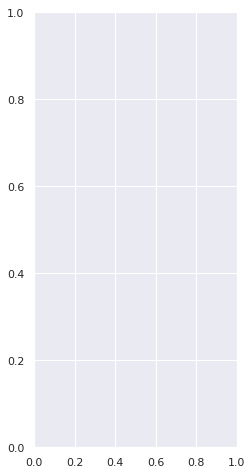

In [0]:
EPOCHS = 50
BATCH_SIZE = 32 

print (x_train.shape)
print (y_train.shape)

history = model.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                       verbose=1, callbacks=None, validation_split=0.10, validation_data=None, 
                    shuffle=True)

(3662, 224, 224, 3)
(3662, 5)
Train on 3295 samples, validate on 367 samples
Epoch 1/50
3295/3295 [==============================] - 4s 1ms/sample - loss: 4.1772 - mae: 0.1713 - accuracy: 0.5778 - val_loss: 5.5256 - val_mae: 0.2230 - val_accuracy: 0.4278
Epoch 2/50
3295/3295 [==============================] - 4s 1ms/sample - loss: 2.8594 - mae: 0.1656 - accuracy: 0.6012 - val_loss: 1.9586 - val_mae: 0.1326 - val_accuracy: 0.6649
Epoch 3/50
3295/3295 [==============================] - 3s 1ms/sample - loss: 3.1148 - mae: 0.1710 - accuracy: 0.5836 - val_loss: 1.6030 - val_mae: 0.1241 - val_accuracy: 0.7030
Epoch 4/50
3295/3295 [==============================] - 4s 1ms/sample - loss: 2.2667 - mae: 0.1610 - accuracy: 0.6015 - val_loss: 1.5478 - val_mae: 0.1578 - val_accuracy: 0.6376
Epoch 5/50
3295/3295 [==============================] - 4s 1ms/sample - loss: 2.7809 - mae: 0.1681 - accuracy: 0.5933 - val_loss: 4.5225 - val_mae: 0.1830 - val_accuracy: 0.5368
Epoch 6/50
3295/3295 [===========

3295/3295 [==============================] - 4s 1ms/sample - loss: 0.8741 - mae: 0.1481 - accuracy: 0.6983 - val_loss: 0.9765 - val_mae: 0.1287 - val_accuracy: 0.7166
Epoch 47/50
3295/3295 [==============================] - 3s 1ms/sample - loss: 0.8909 - mae: 0.1445 - accuracy: 0.7035 - val_loss: 0.7693 - val_mae: 0.1300 - val_accuracy: 0.7439
Epoch 48/50
3295/3295 [==============================] - 3s 1ms/sample - loss: 0.9340 - mae: 0.1482 - accuracy: 0.6968 - val_loss: 0.8814 - val_mae: 0.1247 - val_accuracy: 0.7057
Epoch 49/50
3295/3295 [==============================] - 4s 1ms/sample - loss: 0.8464 - mae: 0.1434 - accuracy: 0.7056 - val_loss: 0.7927 - val_mae: 0.1424 - val_accuracy: 0.7166
Epoch 50/50
3295/3295 [==============================] - 4s 1ms/sample - loss: 0.7964 - mae: 0.1393 - accuracy: 0.7226 - val_loss: 0.8458 - val_mae: 0.1545 - val_accuracy: 0.6349


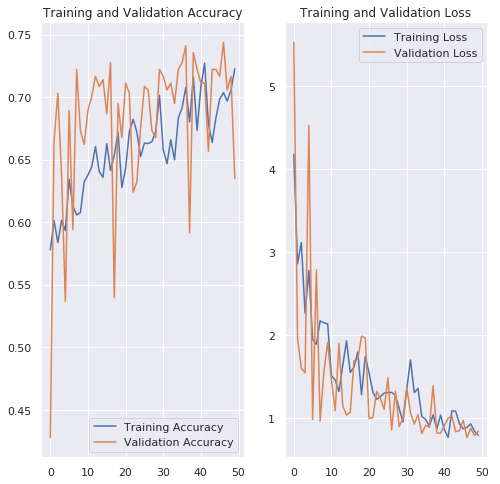

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

In [0]:
EPOCHS = 200
BATCH_SIZE = 32 

print (x_train.shape)
print (y_train.shape)

history = model.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                       verbose=1, callbacks=None, validation_split=0.10, validation_data=None, 
                    shuffle=True)

(3662, 224, 224, 3)
(3662, 5)
Train on 3295 samples, validate on 367 samples
Epoch 1/200
3295/3295 [==============================] - 4s 1ms/sample - loss: 0.7541 - mae: 0.1372 - accuracy: 0.7445 - val_loss: 0.7623 - val_mae: 0.1333 - val_accuracy: 0.7221
Epoch 2/200
3295/3295 [==============================] - 3s 1ms/sample - loss: 0.7962 - mae: 0.1400 - accuracy: 0.7259 - val_loss: 0.9284 - val_mae: 0.1513 - val_accuracy: 0.7193
Epoch 3/200
3295/3295 [==============================] - 4s 1ms/sample - loss: 0.7485 - mae: 0.1366 - accuracy: 0.7375 - val_loss: 0.7524 - val_mae: 0.1387 - val_accuracy: 0.7302
Epoch 4/200
3295/3295 [==============================] - 4s 1ms/sample - loss: 0.7364 - mae: 0.1358 - accuracy: 0.7375 - val_loss: 0.8727 - val_mae: 0.1535 - val_accuracy: 0.7003
Epoch 5/200
3295/3295 [==============================] - 4s 1ms/sample - loss: 0.7425 - mae: 0.1364 - accuracy: 0.7320 - val_loss: 0.7565 - val_mae: 0.1376 - val_accuracy: 0.7139
Epoch 6/200
3295/3295 [=====

3295/3295 [==============================] - 3s 1ms/sample - loss: 0.3258 - mae: 0.0643 - accuracy: 0.8759 - val_loss: 1.2432 - val_mae: 0.1141 - val_accuracy: 0.7384
Epoch 47/200
3295/3295 [==============================] - 4s 1ms/sample - loss: 0.3038 - mae: 0.0613 - accuracy: 0.8862 - val_loss: 1.3565 - val_mae: 0.1301 - val_accuracy: 0.7003
Epoch 48/200
3295/3295 [==============================] - 3s 1ms/sample - loss: 0.3051 - mae: 0.0608 - accuracy: 0.8859 - val_loss: 1.2922 - val_mae: 0.1201 - val_accuracy: 0.7221
Epoch 49/200
3295/3295 [==============================] - 4s 1ms/sample - loss: 0.2681 - mae: 0.0548 - accuracy: 0.9029 - val_loss: 1.2351 - val_mae: 0.1084 - val_accuracy: 0.7357
Epoch 50/200
3295/3295 [==============================] - 3s 1ms/sample - loss: 0.2174 - mae: 0.0463 - accuracy: 0.9199 - val_loss: 1.3656 - val_mae: 0.1137 - val_accuracy: 0.7330
Epoch 51/200
3295/3295 [==============================] - 4s 1ms/sample - loss: 0.2185 - mae: 0.0459 - accuracy: 

3295/3295 [==============================] - 4s 1ms/sample - loss: 0.1206 - mae: 0.0199 - accuracy: 0.9593 - val_loss: 2.3560 - val_mae: 0.1011 - val_accuracy: 0.7548
Epoch 92/200
3295/3295 [==============================] - 3s 1ms/sample - loss: 0.1083 - mae: 0.0171 - accuracy: 0.9675 - val_loss: 2.9420 - val_mae: 0.1113 - val_accuracy: 0.7248
Epoch 93/200
3295/3295 [==============================] - 4s 1ms/sample - loss: 0.0922 - mae: 0.0136 - accuracy: 0.9724 - val_loss: 2.7962 - val_mae: 0.1107 - val_accuracy: 0.7248
Epoch 94/200
3295/3295 [==============================] - 3s 1ms/sample - loss: 0.0690 - mae: 0.0126 - accuracy: 0.9760 - val_loss: 2.8383 - val_mae: 0.1000 - val_accuracy: 0.7520
Epoch 95/200
3295/3295 [==============================] - 3s 1ms/sample - loss: 0.0583 - mae: 0.0096 - accuracy: 0.9815 - val_loss: 3.4049 - val_mae: 0.0976 - val_accuracy: 0.7548
Epoch 96/200
3295/3295 [==============================] - 4s 1ms/sample - loss: 0.2730 - mae: 0.0347 - accuracy: 

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()